In [1]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


## Dataset

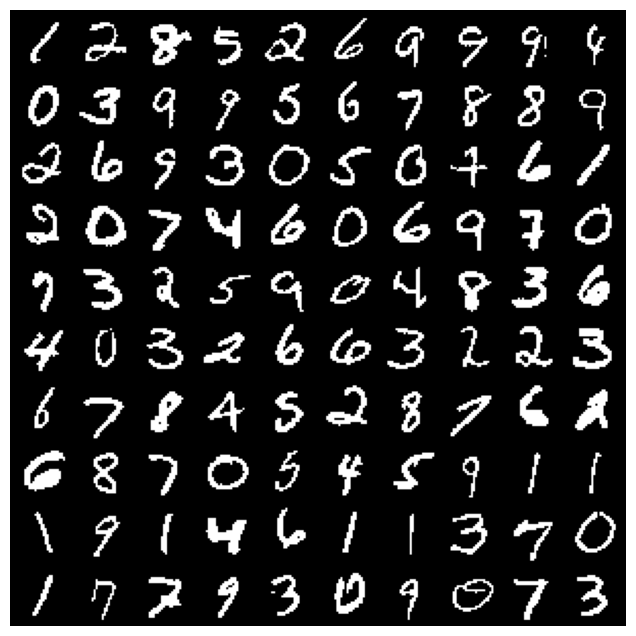

In [2]:
from datasets.binarized_mnist import build_dataloaders
train_loader, test_loader = build_dataloaders(batch_size=100)

# Visualize samples
images, labels = next(iter(train_loader))

# Make a grid of images
grid = utils.make_grid(images, nrow=10, padding=2)

# Plot the grid
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis('off')
plt.show()

In [3]:
from models.discrete_diffusion.mdm import MaskedDiffusion
from models.discrete_diffusion.utils.parametrizations import subs_parametrization
from models.denoising_models.mlp import MLP
from models.denoising_models.unet_with_attention import UNetWithAttention

batch_size = 64
epochs = 20
vocab_size = 2
num_categories = vocab_size + 1  #includes the mask category
mask_index = num_categories - 1
input_shape = (1, 28, 28)
num_timesteps = 100
lr = 1e-3

model = MaskedDiffusion(
    denoising_model=UNetWithAttention(
        num_categories=num_categories,
        embedding_dim=32,
        ch_mult=(2, 4, 8),
        num_res_blocks=2,
        attention_resolutions=(1, 2),
        probs_parametrization_fn=subs_parametrization,
    ),
    # denoising_model=MLP(
    #     input_shape=input_shape,
    #     num_categories=num_categories,
    #     embed_dim=64,
    #     hidden_dim=1024,
    #     encode_time=False,
    #     n_hidden_layers=2,
    #     probs_parametrization_fn=subs_parametrization,
    # ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="cosine",
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

Epoch 1/20, Loss (train): 77.0670, Loss (test): 68.8503, LR: 0.00099384


Epoch 2/20, Loss (train): 67.2283, Loss (test): 65.4034, LR: 0.00097553


Epoch 3/20, Loss (train): 64.8671, Loss (test): 63.5923, LR: 0.00094550


Epoch 4/20, Loss (train): 99.2672, Loss (test): 85.6001, LR: 0.00090451


Epoch 5/20, Loss (train): 82.3755, Loss (test): 82.0731, LR: 0.00085355


Epoch 6/20, Loss (train): 75.7339, Loss (test): 72.1495, LR: 0.00079389


Epoch 7/20, Loss (train): 72.4480, Loss (test): 72.9287, LR: 0.00072700


Epoch 8/20, Loss (train): 70.7376, Loss (test): 69.4259, LR: 0.00065451


Epoch 9/20, Loss (train): 69.3024, Loss (test): 67.9871, LR: 0.00057822


Epoch 10/20, Loss (train): 67.8867, Loss (test): 66.7705, LR: 0.00050000


Epoch 11/20, Loss (train): 67.6387, Loss (test): 66.4197, LR: 0.00042178


Epoch 12/20, Loss (train): 65.9092, Loss (test): 65.1213, LR: 0.00034549


Epoch 13/20, Loss (train): 65.2185, Loss (test): 64.4929, LR: 0.00027300


Epoch 14/20, Loss (train): 64.4222, Loss (test): 64.6916, LR: 0.00020611


Epoch 15/20, Loss (train): 64.3392, Loss (test): 63.4066, LR: 0.00014645


Epoch 16/20, Loss (train): 63.3980, Loss (test): 63.3666, LR: 0.00009549


Epoch 17/20, Loss (train): 63.1580, Loss (test): 62.3492, LR: 0.00005450


Epoch 18/20, Loss (train): 62.4456, Loss (test): 61.9882, LR: 0.00002447


Epoch 19/20, Loss (train): 62.4111, Loss (test): 62.1723, LR: 0.00000616


Epoch 20/20, Loss (train): 62.4585, Loss (test): 62.0432, LR: 0.00000000


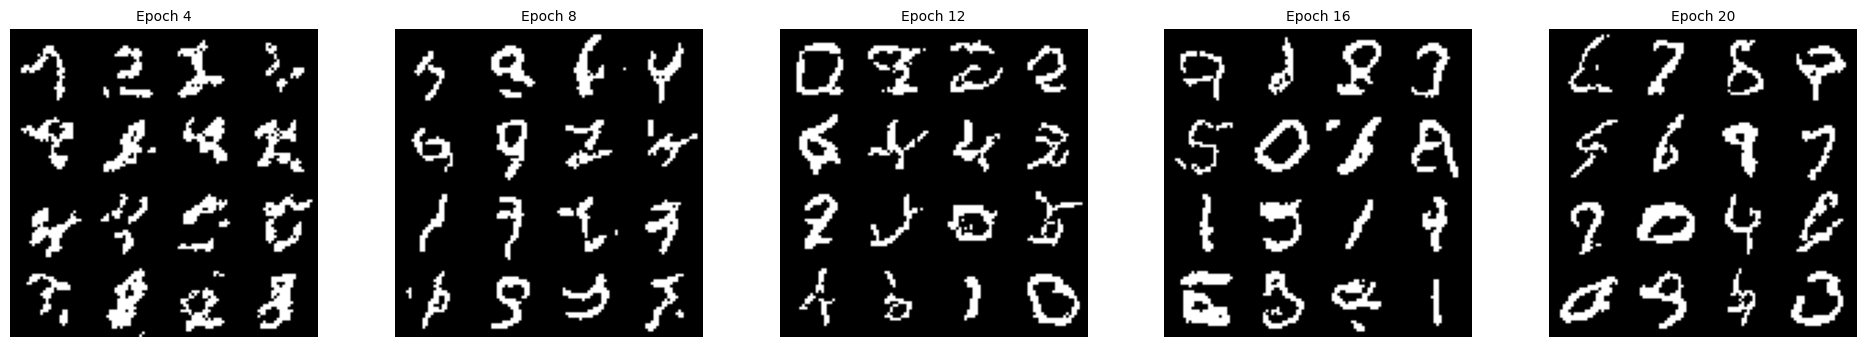

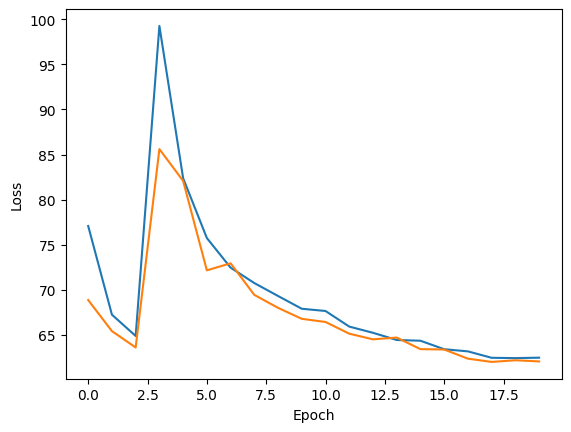

In [4]:
train_loader, test_loader = build_dataloaders(batch_size=batch_size)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(24, 4))
fig_idx = 0

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, labels in train_loader:
        x = x.long().to(device)
        optimizer.zero_grad()
        loss = model(x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
        
    scheduler.step()
    
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for x, labels in test_loader:
            x = x.long().to(device)
            loss = model(x)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss (train): {train_loss:.4f}, Loss (test): {test_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.8f}")
        
    if (epoch + 1) % (epochs // 5) == 0:
        with torch.no_grad():
            samples = model.sample(num_samples=16, device=device).float().cpu()
        grid = utils.make_grid(samples, nrow=4, padding=0)
        ax[fig_idx].imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
        ax[fig_idx].set_title(f"Epoch {epoch + 1}", fontsize=10)
        ax[fig_idx].axis('off')
        fig_idx += 1
        
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

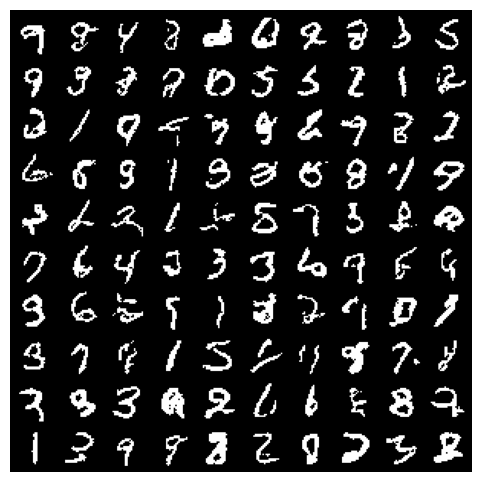

In [5]:
# Visualize samples
model.eval()
with torch.no_grad():
    samples = model.sample(num_samples=100, device=device).float().cpu()
grid = utils.make_grid(samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()

In [6]:
# store model weights
torch.save(model.state_dict(), '../model_weights/mdm_binarized_mnist_256.pth')